# Optimized vs Naive: TensorFlow Metal & MLX Benchmark

This notebook compares **four approaches** across three model sizes:

| Approach | Description |
|----------|-------------|
| TensorFlow (naive) | NumPy arrays, batch=64, default settings |
| TensorFlow (optimized) | tf.data.Dataset, batch=256, prefetch |
| MLX (naive) | Basic loop, batch=64, mx.eval() every batch |
| MLX (optimized) | Larger batch=256, mx.eval() once per epoch |

**Goal:** Find the best achievable performance on Apple Silicon.

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")

# Check MLX availability
try:
    import mlx.core as mx
    import mlx.nn as nn
    import mlx.optimizers as optim
    from mlx.utils import tree_flatten
    MLX_AVAILABLE = True
    print(f"MLX available, device: {mx.default_device()}")
except ImportError:
    MLX_AVAILABLE = False
    print("MLX not available")

import tensorflow as tf
import keras
from keras import layers
from keras.utils import to_categorical

print(f"TensorFlow: {tf.__version__}")
print(f"GPUs: {tf.config.list_physical_devices('GPU')}")

# Store all results
results = []

MLX available, device: Device(gpu, 0)
TensorFlow: 2.18.0
GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Training Functions

### TensorFlow: Naive vs Optimized

In [2]:
def train_tf_naive(model, x_train, y_train, x_test, y_test, epochs=10, batch_size=64):
    """Train TensorFlow model with NumPy arrays (naive approach)."""
    y_train_cat = to_categorical(y_train)
    y_test_cat = to_categorical(y_test)
    
    start = time.time()
    model.fit(x_train, y_train_cat, epochs=epochs, batch_size=batch_size, 
              validation_split=0.1, verbose=1)
    train_time = time.time() - start
    
    _, acc = model.evaluate(x_test, y_test_cat, verbose=0)
    return train_time, acc


def train_tf_optimized(model, x_train, y_train, x_test, y_test, epochs=10, batch_size=256):
    """Train TensorFlow model with tf.data.Dataset (optimized approach).
    
    Optimizations:
    1. tf.data.Dataset instead of NumPy arrays
    2. Larger batch size (256 vs 64)
    3. Prefetching with AUTOTUNE
    4. Caching dataset in memory
    """
    num_classes = len(np.unique(y_train))
    y_train_cat = to_categorical(y_train, num_classes)
    y_test_cat = to_categorical(y_test, num_classes)
    
    # Split for validation
    val_size = int(0.1 * len(x_train))
    x_val, y_val = x_train[:val_size], y_train_cat[:val_size]
    x_train_split, y_train_split = x_train[val_size:], y_train_cat[val_size:]
    
    # Create optimized datasets
    train_ds = tf.data.Dataset.from_tensor_slices((x_train_split, y_train_split))
    train_ds = train_ds.shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val))
    val_ds = val_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test_cat))
    test_ds = test_ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    
    start = time.time()
    model.fit(train_ds, validation_data=val_ds, epochs=epochs, verbose=1)
    train_time = time.time() - start
    
    _, acc = model.evaluate(test_ds, verbose=0)
    return train_time, acc

### MLX: Naive vs Optimized

In [3]:
def batch_iterate(batch_size, x, y):
    """Iterate over batches for MLX training."""
    perm = np.random.permutation(len(x))
    for i in range(0, len(x) - batch_size + 1, batch_size):
        ids = perm[i:i + batch_size]
        yield mx.array(x[ids]), mx.array(y[ids])


def train_mlx_naive(model, x_train, y_train, x_test, y_test, epochs=10, batch_size=64, lr=0.01):
    """Train MLX model with basic loop (naive approach)."""
    def loss_fn(model, x, y):
        return mx.mean(nn.losses.cross_entropy(model(x), y))
    
    optimizer = optim.SGD(learning_rate=lr, momentum=0.9)
    loss_and_grad = nn.value_and_grad(model, loss_fn)
    
    start = time.time()
    for epoch in range(epochs):
        epoch_loss = 0.0
        n_batches = 0
        for xb, yb in batch_iterate(batch_size, x_train, y_train):
            loss, grads = loss_and_grad(model, xb, yb)
            optimizer.update(model, grads)
            mx.eval(model.parameters(), optimizer.state)  # eval every batch (naive)
            epoch_loss += loss.item()
            n_batches += 1
        print(f"  Epoch {epoch+1}/{epochs}, Loss: {epoch_loss/n_batches:.4f}")
    train_time = time.time() - start
    
    # Evaluate
    logits = model(mx.array(x_test))
    preds = mx.argmax(logits, axis=1)
    acc = (preds == mx.array(y_test)).mean().item()
    
    return train_time, acc


def train_mlx_optimized(model, x_train, y_train, x_test, y_test, epochs=10, batch_size=256, lr=0.01):
    """Train MLX model with optimizations.
    
    Optimizations:
    1. Larger batch size (256 vs 64) - better GPU utilization
    2. Less frequent mx.eval() - only once per epoch, not every batch
    3. Accumulate loss without .item() call inside batch loop
    
    Note: mx.compile requires careful handling with nn.value_and_grad.
    The main performance gains come from batch size and eval frequency.
    """
    def loss_fn(model, x, y):
        return mx.mean(nn.losses.cross_entropy(model(x), y))
    
    optimizer = optim.SGD(learning_rate=lr, momentum=0.9)
    loss_and_grad = nn.value_and_grad(model, loss_fn)
    
    start = time.time()
    for epoch in range(epochs):
        losses = []
        for xb, yb in batch_iterate(batch_size, x_train, y_train):
            loss, grads = loss_and_grad(model, xb, yb)
            optimizer.update(model, grads)
            losses.append(loss)
        # Eval once per epoch instead of every batch - major optimization!
        mx.eval(model.parameters(), optimizer.state, *losses)
        epoch_loss = sum(l.item() for l in losses) / len(losses)
        print(f"  Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")
    train_time = time.time() - start
    
    # Evaluate
    logits = model(mx.array(x_test))
    preds = mx.argmax(logits, axis=1)
    acc = (preds == mx.array(y_test)).mean().item()
    
    return train_time, acc

## Model Definitions

In [4]:
def create_tf_mnist_model():
    """Create TensorFlow MNIST CNN (93K params)."""
    model = keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(32, 3, activation='relu'),
        layers.MaxPooling2D(2),
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(2),
        layers.Conv2D(64, 3, activation='relu'),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def create_tf_fashion_model():
    """Create TensorFlow Fashion CNN (412K params)."""
    model = keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(64, 2, padding='same', activation='relu'),
        layers.MaxPooling2D(2),
        layers.Dropout(0.3),
        layers.Conv2D(32, 2, padding='same', activation='relu'),
        layers.MaxPooling2D(2),
        layers.Dropout(0.3),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


def create_tf_vgg16_model():
    """Create TensorFlow VGG16-style model (34M params)."""
    model = keras.Sequential([
        layers.Input(shape=(32, 32, 3)),
        # Block 1
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.Conv2D(64, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(2, 2),
        # Block 2
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.Conv2D(128, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(2, 2),
        # Block 3
        layers.Conv2D(256, 3, padding='same', activation='relu'),
        layers.Conv2D(256, 3, padding='same', activation='relu'),
        layers.Conv2D(256, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(2, 2),
        # Block 4
        layers.Conv2D(512, 3, padding='same', activation='relu'),
        layers.Conv2D(512, 3, padding='same', activation='relu'),
        layers.Conv2D(512, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(2, 2),
        # Block 5
        layers.Conv2D(512, 3, padding='same', activation='relu'),
        layers.Conv2D(512, 3, padding='same', activation='relu'),
        layers.Conv2D(512, 3, padding='same', activation='relu'),
        layers.MaxPooling2D(2, 2),
        # Classifier
        layers.Flatten(),
        layers.Dense(4096, activation='relu'),
        layers.Dense(4096, activation='relu'),
        layers.Dense(100, activation='softmax')
    ])
    model.compile(optimizer=keras.optimizers.Adam(1e-4), 
                  loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [5]:
if MLX_AVAILABLE:
    class MLX_MNIST(nn.Module):
        """MLX MNIST CNN (93K params)."""
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
            self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
            self.conv3 = nn.Conv2d(64, 64, kernel_size=3)
            self.fc1 = nn.Linear(64 * 3 * 3, 64)
            self.fc2 = nn.Linear(64, 10)
        
        def __call__(self, x):
            x = nn.relu(self.conv1(x))
            x = nn.MaxPool2d(2, 2)(x)
            x = nn.relu(self.conv2(x))
            x = nn.MaxPool2d(2, 2)(x)
            x = nn.relu(self.conv3(x))
            x = x.reshape(x.shape[0], -1)
            x = nn.relu(self.fc1(x))
            return self.fc2(x)

    class MLX_Fashion(nn.Module):
        """MLX Fashion CNN (412K params)."""
        def __init__(self):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 64, kernel_size=2, padding=1)
            self.conv2 = nn.Conv2d(64, 32, kernel_size=2, padding=1)
            self.fc1 = nn.Linear(32 * 7 * 7, 256)
            self.fc2 = nn.Linear(256, 10)
            self.dropout1 = nn.Dropout(0.3)
            self.dropout2 = nn.Dropout(0.3)
            self.dropout3 = nn.Dropout(0.5)

        def __call__(self, x):
            x = nn.relu(self.conv1(x))
            x = nn.MaxPool2d(2, 2)(x)
            x = self.dropout1(x)
            x = nn.relu(self.conv2(x))
            x = nn.MaxPool2d(2, 2)(x)
            x = self.dropout2(x)
            x = x.reshape(x.shape[0], -1)
            x = nn.relu(self.fc1(x))
            x = self.dropout3(x)
            return self.fc2(x)

    class MLX_VGG16(nn.Module):
        """MLX VGG16-style model (34M params)."""
        def __init__(self):
            super().__init__()
            # Block 1
            self.conv1_1 = nn.Conv2d(3, 64, 3, padding=1)
            self.conv1_2 = nn.Conv2d(64, 64, 3, padding=1)
            # Block 2
            self.conv2_1 = nn.Conv2d(64, 128, 3, padding=1)
            self.conv2_2 = nn.Conv2d(128, 128, 3, padding=1)
            # Block 3
            self.conv3_1 = nn.Conv2d(128, 256, 3, padding=1)
            self.conv3_2 = nn.Conv2d(256, 256, 3, padding=1)
            self.conv3_3 = nn.Conv2d(256, 256, 3, padding=1)
            # Block 4
            self.conv4_1 = nn.Conv2d(256, 512, 3, padding=1)
            self.conv4_2 = nn.Conv2d(512, 512, 3, padding=1)
            self.conv4_3 = nn.Conv2d(512, 512, 3, padding=1)
            # Block 5
            self.conv5_1 = nn.Conv2d(512, 512, 3, padding=1)
            self.conv5_2 = nn.Conv2d(512, 512, 3, padding=1)
            self.conv5_3 = nn.Conv2d(512, 512, 3, padding=1)
            # Classifier
            self.fc1 = nn.Linear(512, 4096)
            self.fc2 = nn.Linear(4096, 4096)
            self.fc3 = nn.Linear(4096, 100)
        
        def __call__(self, x):
            # Block 1
            x = nn.relu(self.conv1_1(x))
            x = nn.relu(self.conv1_2(x))
            x = nn.MaxPool2d(2, 2)(x)
            # Block 2
            x = nn.relu(self.conv2_1(x))
            x = nn.relu(self.conv2_2(x))
            x = nn.MaxPool2d(2, 2)(x)
            # Block 3
            x = nn.relu(self.conv3_1(x))
            x = nn.relu(self.conv3_2(x))
            x = nn.relu(self.conv3_3(x))
            x = nn.MaxPool2d(2, 2)(x)
            # Block 4
            x = nn.relu(self.conv4_1(x))
            x = nn.relu(self.conv4_2(x))
            x = nn.relu(self.conv4_3(x))
            x = nn.MaxPool2d(2, 2)(x)
            # Block 5
            x = nn.relu(self.conv5_1(x))
            x = nn.relu(self.conv5_2(x))
            x = nn.relu(self.conv5_3(x))
            x = nn.MaxPool2d(2, 2)(x)
            # Classifier
            x = x.reshape(x.shape[0], -1)
            x = nn.relu(self.fc1(x))
            x = nn.relu(self.fc2(x))
            return self.fc3(x)

## Load Datasets

In [6]:
from keras.datasets import mnist, fashion_mnist, cifar100

# MNIST
(x_train_mnist, y_train_mnist), (x_test_mnist, y_test_mnist) = mnist.load_data()
x_train_mnist = x_train_mnist.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test_mnist = x_test_mnist.reshape(-1, 28, 28, 1).astype('float32') / 255.0
print(f"MNIST: {x_train_mnist.shape}")

# Fashion MNIST
(x_train_fashion, y_train_fashion), (x_test_fashion, y_test_fashion) = fashion_mnist.load_data()
x_train_fashion = x_train_fashion.reshape(-1, 28, 28, 1).astype('float32') / 255.0
x_test_fashion = x_test_fashion.reshape(-1, 28, 28, 1).astype('float32') / 255.0
print(f"Fashion MNIST: {x_train_fashion.shape}")

# CIFAR-100
(x_train_cifar, y_train_cifar), (x_test_cifar, y_test_cifar) = cifar100.load_data()
x_train_cifar = x_train_cifar.astype('float32') / 255.0
x_test_cifar = x_test_cifar.astype('float32') / 255.0
y_train_cifar = y_train_cifar.flatten()
y_test_cifar = y_test_cifar.flatten()
print(f"CIFAR-100: {x_train_cifar.shape}")

MNIST: (60000, 28, 28, 1)
Fashion MNIST: (60000, 28, 28, 1)
CIFAR-100: (50000, 32, 32, 3)


---
## Benchmark 1: MNIST CNN (93K parameters)

In [16]:
print("=" * 60)
print("MNIST - TensorFlow (NAIVE: NumPy arrays, batch=64)")
print("=" * 60)

tf_mnist_naive = create_tf_mnist_model()
print(f"Parameters: {tf_mnist_naive.count_params():,}")

tf_naive_time_mnist, tf_naive_acc_mnist = train_tf_naive(
    tf_mnist_naive, x_train_mnist, y_train_mnist, x_test_mnist, y_test_mnist,
    epochs=10, batch_size=64
)
print(f"\nTime: {tf_naive_time_mnist:.2f}s, Accuracy: {tf_naive_acc_mnist:.4f}")

MNIST - TensorFlow (NAIVE: NumPy arrays, batch=64)
Parameters: 93,322
Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9340 - loss: 0.2099 - val_accuracy: 0.9825 - val_loss: 0.0621
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9822 - loss: 0.0578 - val_accuracy: 0.9857 - val_loss: 0.0511
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9881 - loss: 0.0408 - val_accuracy: 0.9905 - val_loss: 0.0363
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9907 - loss: 0.0320 - val_accuracy: 0.9907 - val_loss: 0.0399
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.9919 - loss: 0.0272 - val_accuracy: 0.9897 - val_loss: 0.0511
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9927 - loss: 0.0251 - val_accuracy: 0.9887 - val_loss: 0.0629
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.9943 - loss: 0.0197 - val_accuracy: 0.9913 - val_loss: 0.0517
Epoch 8/10
844/844 ━━━━━━━━━━━━━━━

In [17]:
print("=" * 60)
print("MNIST - TensorFlow (OPTIMIZED: tf.data, batch=256, prefetch)")
print("=" * 60)

tf_mnist_opt = create_tf_mnist_model()
print(f"Parameters: {tf_mnist_opt.count_params():,}")

tf_opt_time_mnist, tf_opt_acc_mnist = train_tf_optimized(
    tf_mnist_opt, x_train_mnist, y_train_mnist, x_test_mnist, y_test_mnist,
    epochs=10, batch_size=256
)
print(f"\nTime: {tf_opt_time_mnist:.2f}s, Accuracy: {tf_opt_acc_mnist:.4f}")

MNIST - TensorFlow (OPTIMIZED: tf.data, batch=256, prefetch)
Parameters: 93,322
Epoch 1/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.8685 - loss: 0.4194 - val_accuracy: 0.9662 - val_loss: 0.1160
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - accuracy: 0.9700 - loss: 0.0974 - val_accuracy: 0.9763 - val_loss: 0.0775
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9800 - loss: 0.0638 - val_accuracy: 0.9837 - val_loss: 0.0567
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9846 - loss: 0.0516 - val_accuracy: 0.9843 - val_loss: 0.0527
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9876 - loss: 0.0418 - val_accuracy: 0.9837 - val_loss: 0.0560
Epoch 6/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.9887 - loss: 0.0371 - val_accuracy: 0.9857 - val_loss: 0.0493
Epoch 7/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.9905 - loss: 0.0314 - val_accuracy: 0.9868 - val_loss: 0.0609
Epoch 8/10
211/21

In [18]:
print("=" * 60)
print("MNIST - MLX (NAIVE: basic loop, batch=64)")
print("=" * 60)

if MLX_AVAILABLE:
    mlx_mnist_naive = MLX_MNIST()
    mx.eval(mlx_mnist_naive.parameters())
    n_params = sum(p.size for _, p in tree_flatten(mlx_mnist_naive.parameters()))
    print(f"Parameters: {n_params:,}")
    
    mlx_naive_time_mnist, mlx_naive_acc_mnist = train_mlx_naive(
        mlx_mnist_naive, x_train_mnist, y_train_mnist, x_test_mnist, y_test_mnist,
        epochs=10, batch_size=64
    )
    print(f"\nTime: {mlx_naive_time_mnist:.2f}s, Accuracy: {mlx_naive_acc_mnist:.4f}")

MNIST - MLX (NAIVE: basic loop, batch=64)
Parameters: 93,322
  Epoch 1/10, Loss: 0.4314
  Epoch 2/10, Loss: 0.0767
  Epoch 3/10, Loss: 0.0511
  Epoch 4/10, Loss: 0.0396
  Epoch 5/10, Loss: 0.0322
  Epoch 6/10, Loss: 0.0260
  Epoch 7/10, Loss: 0.0223
  Epoch 8/10, Loss: 0.0197
  Epoch 9/10, Loss: 0.0166
  Epoch 10/10, Loss: 0.0145

Time: 16.37s, Accuracy: 0.9910


In [19]:
print("=" * 60)
print("MNIST - MLX (OPTIMIZED: batch=256, eval once per epoch)")
print("=" * 60)

if MLX_AVAILABLE:
    mlx_mnist_opt = MLX_MNIST()
    mx.eval(mlx_mnist_opt.parameters())
    n_params = sum(p.size for _, p in tree_flatten(mlx_mnist_opt.parameters()))
    print(f"Parameters: {n_params:,}")
    
    mlx_opt_time_mnist, mlx_opt_acc_mnist = train_mlx_optimized(
        mlx_mnist_opt, x_train_mnist, y_train_mnist, x_test_mnist, y_test_mnist,
        epochs=10, batch_size=256
    )
    print(f"\nTime: {mlx_opt_time_mnist:.2f}s, Accuracy: {mlx_opt_acc_mnist:.4f}")
    
    results.append({
        'benchmark': 'MNIST CNN',
        'params': '93K',
        'tf_naive': tf_naive_time_mnist,
        'tf_opt': tf_opt_time_mnist,
        'mlx_naive': mlx_naive_time_mnist,
        'mlx_opt': mlx_opt_time_mnist,
        'tf_naive_acc': tf_naive_acc_mnist,
        'tf_opt_acc': tf_opt_acc_mnist,
        'mlx_naive_acc': mlx_naive_acc_mnist,
        'mlx_opt_acc': mlx_opt_acc_mnist
    })

MNIST - MLX (OPTIMIZED: batch=256, eval once per epoch)
Parameters: 93,322
  Epoch 1/10, Loss: 1.1662
  Epoch 2/10, Loss: 0.2177
  Epoch 3/10, Loss: 0.1234
  Epoch 4/10, Loss: 0.0871
  Epoch 5/10, Loss: 0.0675
  Epoch 6/10, Loss: 0.0591
  Epoch 7/10, Loss: 0.0520
  Epoch 8/10, Loss: 0.0459
  Epoch 9/10, Loss: 0.0423
  Epoch 10/10, Loss: 0.0385

Time: 11.64s, Accuracy: 0.9869


---
## Benchmark 2: Fashion MNIST CNN (412K parameters)

In [20]:
print("=" * 60)
print("Fashion MNIST - TensorFlow (NAIVE: NumPy arrays, batch=64)")
print("=" * 60)

tf_fashion_naive = create_tf_fashion_model()
print(f"Parameters: {tf_fashion_naive.count_params():,}")

tf_naive_time_fashion, tf_naive_acc_fashion = train_tf_naive(
    tf_fashion_naive, x_train_fashion, y_train_fashion, x_test_fashion, y_test_fashion,
    epochs=10, batch_size=64
)
print(f"\nTime: {tf_naive_time_fashion:.2f}s, Accuracy: {tf_naive_acc_fashion:.4f}")

Fashion MNIST - TensorFlow (NAIVE: NumPy arrays, batch=64)
Parameters: 412,778
Epoch 1/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.7670 - loss: 0.6502 - val_accuracy: 0.8298 - val_loss: 0.4547
Epoch 2/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8331 - loss: 0.4827 - val_accuracy: 0.8742 - val_loss: 0.3571
Epoch 3/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8428 - loss: 0.4606 - val_accuracy: 0.8695 - val_loss: 0.3720
Epoch 4/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - accuracy: 0.8466 - loss: 0.4644 - val_accuracy: 0.8777 - val_loss: 0.3593
Epoch 5/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8455 - loss: 0.4726 - val_accuracy: 0.8672 - val_loss: 0.4081
Epoch 6/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8420 - loss: 0.5004 - val_accuracy: 0.8643 - val_loss: 0.4128
Epoch 7/10
844/844 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - accuracy: 0.8358 - loss: 0.5415 - val_accuracy: 0.8710 - val_loss: 0.4128
Epoch 8/10
844

In [21]:
print("=" * 60)
print("Fashion MNIST - TensorFlow (OPTIMIZED: tf.data, batch=256, prefetch)")
print("=" * 60)

tf_fashion_opt = create_tf_fashion_model()
print(f"Parameters: {tf_fashion_opt.count_params():,}")

tf_opt_time_fashion, tf_opt_acc_fashion = train_tf_optimized(
    tf_fashion_opt, x_train_fashion, y_train_fashion, x_test_fashion, y_test_fashion,
    epochs=10, batch_size=256
)
print(f"\nTime: {tf_opt_time_fashion:.2f}s, Accuracy: {tf_opt_acc_fashion:.4f}")

Fashion MNIST - TensorFlow (OPTIMIZED: tf.data, batch=256, prefetch)
Parameters: 412,778
Epoch 1/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.7127 - loss: 0.7750 - val_accuracy: 0.8437 - val_loss: 0.4503
Epoch 2/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.8096 - loss: 0.5320 - val_accuracy: 0.8588 - val_loss: 0.4089
Epoch 3/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8239 - loss: 0.5089 - val_accuracy: 0.8608 - val_loss: 0.4033
Epoch 4/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8296 - loss: 0.5095 - val_accuracy: 0.8723 - val_loss: 0.3872
Epoch 5/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8328 - loss: 0.5106 - val_accuracy: 0.8667 - val_loss: 0.4066
Epoch 6/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8303 - loss: 0.5301 - val_accuracy: 0.8762 - val_loss: 0.3868
Epoch 7/10
211/211 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.8291 - loss: 0.5467 - val_accuracy: 0.8485 - val_loss: 0.4881
Epoch 8/

In [22]:
print("=" * 60)
print("Fashion MNIST - MLX (NAIVE: basic loop, batch=64)")
print("=" * 60)

if MLX_AVAILABLE:
    mlx_fashion_naive = MLX_Fashion()
    mx.eval(mlx_fashion_naive.parameters())
    n_params = sum(p.size for _, p in tree_flatten(mlx_fashion_naive.parameters()))
    print(f"Parameters: {n_params:,}")
    
    mlx_naive_time_fashion, mlx_naive_acc_fashion = train_mlx_naive(
        mlx_fashion_naive, x_train_fashion, y_train_fashion, x_test_fashion, y_test_fashion,
        epochs=10, batch_size=64
    )
    print(f"\nTime: {mlx_naive_time_fashion:.2f}s, Accuracy: {mlx_naive_acc_fashion:.4f}")

Fashion MNIST - MLX (NAIVE: basic loop, batch=64)
Parameters: 412,778
  Epoch 1/10, Loss: 0.7710
  Epoch 2/10, Loss: 0.4887
  Epoch 3/10, Loss: 0.4263
  Epoch 4/10, Loss: 0.3939
  Epoch 5/10, Loss: 0.3718
  Epoch 6/10, Loss: 0.3551
  Epoch 7/10, Loss: 0.3414
  Epoch 8/10, Loss: 0.3296
  Epoch 9/10, Loss: 0.3211
  Epoch 10/10, Loss: 0.3123

Time: 28.02s, Accuracy: 0.8775


In [23]:
print("=" * 60)
print("Fashion MNIST - MLX (OPTIMIZED: batch=256, eval once per epoch)")
print("=" * 60)

if MLX_AVAILABLE:
    mlx_fashion_opt = MLX_Fashion()
    mx.eval(mlx_fashion_opt.parameters())
    n_params = sum(p.size for _, p in tree_flatten(mlx_fashion_opt.parameters()))
    print(f"Parameters: {n_params:,}")
    
    mlx_opt_time_fashion, mlx_opt_acc_fashion = train_mlx_optimized(
        mlx_fashion_opt, x_train_fashion, y_train_fashion, x_test_fashion, y_test_fashion,
        epochs=10, batch_size=256
    )
    print(f"\nTime: {mlx_opt_time_fashion:.2f}s, Accuracy: {mlx_opt_acc_fashion:.4f}")
    
    results.append({
        'benchmark': 'Fashion CNN',
        'params': '412K',
        'tf_naive': tf_naive_time_fashion,
        'tf_opt': tf_opt_time_fashion,
        'mlx_naive': mlx_naive_time_fashion,
        'mlx_opt': mlx_opt_time_fashion,
        'tf_naive_acc': tf_naive_acc_fashion,
        'tf_opt_acc': tf_opt_acc_fashion,
        'mlx_naive_acc': mlx_naive_acc_fashion,
        'mlx_opt_acc': mlx_opt_acc_fashion
    })

Fashion MNIST - MLX (OPTIMIZED: batch=256, eval once per epoch)
Parameters: 412,778
  Epoch 1/10, Loss: 1.1134
  Epoch 2/10, Loss: 0.7268
  Epoch 3/10, Loss: 0.6050
  Epoch 4/10, Loss: 0.5404
  Epoch 5/10, Loss: 0.5004
  Epoch 6/10, Loss: 0.4686
  Epoch 7/10, Loss: 0.4491
  Epoch 8/10, Loss: 0.4309
  Epoch 9/10, Loss: 0.4169
  Epoch 10/10, Loss: 0.4012

Time: 24.08s, Accuracy: 0.8464


---
## Benchmark 3: VGG16 on CIFAR-100 (34M parameters)

**Note:** This is a large model. Training takes longer but shows where GPU compute dominates.

In [7]:
print("=" * 60)
print("VGG16 CIFAR-100 - TensorFlow (NAIVE: NumPy arrays, batch=128)")
print("=" * 60)

tf_vgg_naive = create_tf_vgg16_model()
print(f"Parameters: {tf_vgg_naive.count_params():,}")

tf_naive_time_vgg, tf_naive_acc_vgg = train_tf_naive(
    tf_vgg_naive, x_train_cifar, y_train_cifar, x_test_cifar, y_test_cifar,
    epochs=10, batch_size=128
)
print(f"\nTime: {tf_naive_time_vgg:.2f}s, Accuracy: {tf_naive_acc_vgg:.4f}")

VGG16 CIFAR-100 - TensorFlow (NAIVE: NumPy arrays, batch=128)
Parameters: 34,006,948


2026-02-04 01:28:17.510705: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4 Pro
2026-02-04 01:28:17.510817: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 48.00 GB
2026-02-04 01:28:17.510823: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 18.72 GB
I0000 00:00:1770168497.510851  675130 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1770168497.510894  675130 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/10


2026-02-04 01:28:18.410327: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


352/352 ━━━━━━━━━━━━━━━━━━━━ 27s 73ms/step - accuracy: 0.0096 - loss: 4.6053 - val_accuracy: 0.0070 - val_loss: 4.6058
Epoch 2/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.0088 - loss: 4.6054 - val_accuracy: 0.0070 - val_loss: 4.6060
Epoch 3/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.0093 - loss: 4.6053 - val_accuracy: 0.0070 - val_loss: 4.6063
Epoch 4/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.0097 - loss: 4.6053 - val_accuracy: 0.0070 - val_loss: 4.6065
Epoch 5/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.0097 - loss: 4.6053 - val_accuracy: 0.0070 - val_loss: 4.6067
Epoch 6/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 25s 71ms/step - accuracy: 0.0100 - loss: 4.6053 - val_accuracy: 0.0070 - val_loss: 4.6069
Epoch 7/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.0101 - loss: 4.6053 - val_accuracy: 0.0070 - val_loss: 4.6070
Epoch 8/10
352/352 ━━━━━━━━━━━━━━━━━━━━ 25s 70ms/step - accuracy: 0.0098 - loss: 4.6053 - val_accurac

In [8]:
print("=" * 60)
print("VGG16 CIFAR-100 - TensorFlow (OPTIMIZED: tf.data, batch=256, prefetch)")
print("=" * 60)

tf_vgg_opt = create_tf_vgg16_model()
print(f"Parameters: {tf_vgg_opt.count_params():,}")

tf_opt_time_vgg, tf_opt_acc_vgg = train_tf_optimized(
    tf_vgg_opt, x_train_cifar, y_train_cifar, x_test_cifar, y_test_cifar,
    epochs=10, batch_size=256
)
print(f"\nTime: {tf_opt_time_vgg:.2f}s, Accuracy: {tf_opt_acc_vgg:.4f}")

VGG16 CIFAR-100 - TensorFlow (OPTIMIZED: tf.data, batch=256, prefetch)
Parameters: 34,006,948
Epoch 1/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.0187 - loss: 4.4870 - val_accuracy: 0.0254 - val_loss: 4.2792
Epoch 2/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.0460 - loss: 4.1259 - val_accuracy: 0.0568 - val_loss: 3.9716
Epoch 3/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.0689 - loss: 3.9197 - val_accuracy: 0.0754 - val_loss: 3.8621
Epoch 4/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.0848 - loss: 3.8527 - val_accuracy: 0.0878 - val_loss: 3.8117
Epoch 5/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.1041 - loss: 3.7586 - val_accuracy: 0.0896 - val_loss: 3.8154
Epoch 6/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.1238 - loss: 3.6586 - val_accuracy: 0.1284 - val_loss: 3.6612
Epoch 7/10
176/176 ━━━━━━━━━━━━━━━━━━━━ 19s 109ms/step - accuracy: 0.1394 - loss: 3.5748 - val_accuracy: 0.1398 - val_lo

In [15]:
print("=" * 60)
print("VGG16 CIFAR-100 - MLX (NAIVE: basic loop, batch=128)")
print("=" * 60)

if MLX_AVAILABLE:
    mlx_vgg_naive = MLX_VGG16()
    mx.eval(mlx_vgg_naive.parameters())
    n_params = sum(p.size for _, p in tree_flatten(mlx_vgg_naive.parameters()))
    print(f"Parameters: {n_params:,}")
    
    mlx_naive_time_vgg, mlx_naive_acc_vgg = train_mlx_naive(
        mlx_vgg_naive, x_train_cifar, y_train_cifar, x_test_cifar, y_test_cifar,
        epochs=10, batch_size=128, lr=0.01
    )
    print(f"\nTime: {mlx_naive_time_vgg:.2f}s, Accuracy: {mlx_naive_acc_vgg:.4f}")

VGG16 CIFAR-100 - MLX (NAIVE: basic loop, batch=128)
Parameters: 34,006,948
  Epoch 1/10, Loss: 4.6058
  Epoch 2/10, Loss: 4.6058
  Epoch 3/10, Loss: 4.6057
  Epoch 4/10, Loss: 4.6057
  Epoch 5/10, Loss: 4.6057
  Epoch 6/10, Loss: 4.6057
  Epoch 7/10, Loss: 4.6057
  Epoch 8/10, Loss: 4.6057
  Epoch 9/10, Loss: 4.6057
  Epoch 10/10, Loss: 4.6057

Time: 253.94s, Accuracy: 0.0100


In [10]:
print("=" * 60)
print("VGG16 CIFAR-100 - MLX (OPTIMIZED: batch=256, eval once per epoch)")
print("=" * 60)

if MLX_AVAILABLE:
    mlx_vgg_opt = MLX_VGG16()
    mx.eval(mlx_vgg_opt.parameters())
    n_params = sum(p.size for _, p in tree_flatten(mlx_vgg_opt.parameters()))
    print(f"Parameters: {n_params:,}")
    
    mlx_opt_time_vgg, mlx_opt_acc_vgg = train_mlx_optimized(
        mlx_vgg_opt, x_train_cifar, y_train_cifar, x_test_cifar, y_test_cifar,
        epochs=10, batch_size=256, lr=0.01
    )
    print(f"\nTime: {mlx_opt_time_vgg:.2f}s, Accuracy: {mlx_opt_acc_vgg:.4f}")
    
    results.append({
        'benchmark': 'VGG16',
        'params': '34M',
        'tf_naive': tf_naive_time_vgg,
        'tf_opt': tf_opt_time_vgg,
        'mlx_naive': mlx_naive_time_vgg,
        'mlx_opt': mlx_opt_time_vgg,
        'tf_naive_acc': tf_naive_acc_vgg,
        'tf_opt_acc': tf_opt_acc_vgg,
        'mlx_naive_acc': mlx_naive_acc_vgg,
        'mlx_opt_acc': mlx_opt_acc_vgg
    })

VGG16 CIFAR-100 - MLX (OPTIMIZED: batch=256, eval once per epoch)
Parameters: 34,006,948
  Epoch 1/10, Loss: 4.6052
  Epoch 2/10, Loss: 4.6052
  Epoch 3/10, Loss: 4.6052
  Epoch 4/10, Loss: 4.6052
  Epoch 5/10, Loss: 4.6052
  Epoch 6/10, Loss: 4.6052
  Epoch 7/10, Loss: 4.6052
  Epoch 8/10, Loss: 4.6052
  Epoch 9/10, Loss: 4.6052
  Epoch 10/10, Loss: 4.6052

Time: 241.46s, Accuracy: 0.0100


---
## Final Results & Analysis

In [24]:
print("=" * 70)
print("FINAL RESULTS: Naive vs Optimized on M4 Pro")
print("=" * 70)

df = pd.DataFrame(results)

# Calculate speedups
df['tf_speedup'] = df['tf_naive'] / df['tf_opt']
df['mlx_speedup'] = df['mlx_naive'] / df['mlx_opt']
df['best_naive'] = df[['tf_naive', 'mlx_naive']].min(axis=1)
df['best_opt'] = df[['tf_opt', 'mlx_opt']].min(axis=1)
df['overall_speedup'] = df['best_naive'] / df['best_opt']

print("\n" + "=" * 70)
print("SUMMARY TABLE")
print("=" * 70)
print(f"\n{'Benchmark':<15} {'TF Naive':>10} {'TF Opt':>10} {'MLX Naive':>10} {'MLX Opt':>10} {'Best':>10}")
print("-" * 70)

for _, row in df.iterrows():
    times = [row['tf_naive'], row['tf_opt'], row['mlx_naive'], row['mlx_opt']]
    best = min(times)
    best_label = ['TF Naive', 'TF Opt', 'MLX Naive', 'MLX Opt'][times.index(best)]
    print(f"{row['benchmark']:<15} {row['tf_naive']:>9.1f}s {row['tf_opt']:>9.1f}s {row['mlx_naive']:>9.1f}s {row['mlx_opt']:>9.1f}s {best_label:>10}")

print("\n" + "=" * 70)
print("OPTIMIZATION IMPACT")
print("=" * 70)
for _, row in df.iterrows():
    print(f"\n{row['benchmark']} ({row['params']} params):")
    print(f"  TensorFlow: {row['tf_naive']:.1f}s → {row['tf_opt']:.1f}s ({row['tf_speedup']:.2f}x faster)")
    print(f"  MLX:        {row['mlx_naive']:.1f}s → {row['mlx_opt']:.1f}s ({row['mlx_speedup']:.2f}x faster)")

FINAL RESULTS: Naive vs Optimized on M4 Pro

SUMMARY TABLE

Benchmark         TF Naive     TF Opt  MLX Naive    MLX Opt       Best
----------------------------------------------------------------------
VGG16               250.7s     193.2s     252.2s     241.5s     TF Opt
MNIST CNN            77.2s      24.8s      16.4s      11.6s    MLX Opt
Fashion CNN          95.3s      28.2s      28.0s      24.1s    MLX Opt

OPTIMIZATION IMPACT

VGG16 (34M params):
  TensorFlow: 250.7s → 193.2s (1.30x faster)
  MLX:        252.2s → 241.5s (1.04x faster)

MNIST CNN (93K params):
  TensorFlow: 77.2s → 24.8s (3.11x faster)
  MLX:        16.4s → 11.6s (1.41x faster)

Fashion CNN (412K params):
  TensorFlow: 95.3s → 28.2s (3.37x faster)
  MLX:        28.0s → 24.1s (1.16x faster)


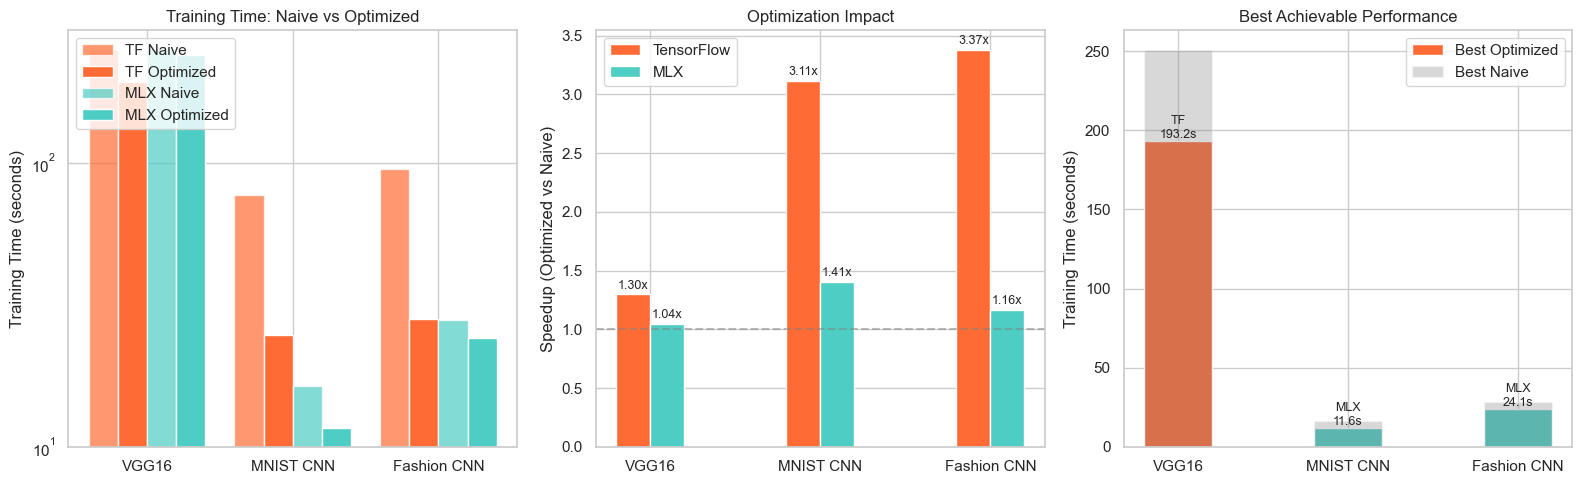

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

benchmarks = [r['benchmark'] for r in results]
x = np.arange(len(benchmarks))
width = 0.2

# Chart 1: Training Time Comparison (all 4 approaches)
ax1 = axes[0]
ax1.bar(x - 1.5*width, [r['tf_naive'] for r in results], width, label='TF Naive', color='#FF6B35', alpha=0.7)
ax1.bar(x - 0.5*width, [r['tf_opt'] for r in results], width, label='TF Optimized', color='#FF6B35')
ax1.bar(x + 0.5*width, [r['mlx_naive'] for r in results], width, label='MLX Naive', color='#4ECDC4', alpha=0.7)
ax1.bar(x + 1.5*width, [r['mlx_opt'] for r in results], width, label='MLX Optimized', color='#4ECDC4')
ax1.set_ylabel('Training Time (seconds)')
ax1.set_title('Training Time: Naive vs Optimized')
ax1.set_xticks(x)
ax1.set_xticklabels(benchmarks)
ax1.legend(loc='upper left')
ax1.set_yscale('log')

# Chart 2: Optimization Speedup
ax2 = axes[1]
tf_speedups = [r['tf_naive']/r['tf_opt'] for r in results]
mlx_speedups = [r['mlx_naive']/r['mlx_opt'] for r in results]
ax2.bar(x - width/2, tf_speedups, width, label='TensorFlow', color='#FF6B35')
ax2.bar(x + width/2, mlx_speedups, width, label='MLX', color='#4ECDC4')
ax2.axhline(y=1, color='gray', linestyle='--', alpha=0.5)
ax2.set_ylabel('Speedup (Optimized vs Naive)')
ax2.set_title('Optimization Impact')
ax2.set_xticks(x)
ax2.set_xticklabels(benchmarks)
ax2.legend()
for i, (tf_s, mlx_s) in enumerate(zip(tf_speedups, mlx_speedups)):
    ax2.text(i - width/2, tf_s + 0.05, f'{tf_s:.2f}x', ha='center', fontsize=9)
    ax2.text(i + width/2, mlx_s + 0.05, f'{mlx_s:.2f}x', ha='center', fontsize=9)

# Chart 3: Best Achievable Performance
ax3 = axes[2]
best_times = [min(r['tf_opt'], r['mlx_opt']) for r in results]
naive_times = [min(r['tf_naive'], r['mlx_naive']) for r in results]
colors = ['#4ECDC4' if r['mlx_opt'] < r['tf_opt'] else '#FF6B35' for r in results]
ax3.bar(x, best_times, width*2, color=colors, label='Best Optimized')
ax3.bar(x, naive_times, width*2, color='gray', alpha=0.3, label='Best Naive')
ax3.set_ylabel('Training Time (seconds)')
ax3.set_title('Best Achievable Performance')
ax3.set_xticks(x)
ax3.set_xticklabels(benchmarks)
ax3.legend()
for i, (best, naive) in enumerate(zip(best_times, naive_times)):
    winner = 'MLX' if results[i]['mlx_opt'] < results[i]['tf_opt'] else 'TF'
    ax3.text(i, best + 2, f'{winner}\n{best:.1f}s', ha='center', fontsize=9)

plt.tight_layout()
plt.savefig('../assets/optimized_benchmark.png', dpi=150, bbox_inches='tight')
plt.show()

In [26]:
# Export results to JSON for README
import json

export_data = {
    'hardware': 'M4 Pro 16-core GPU',
    'date': pd.Timestamp.now().isoformat(),
    'results': results
}

with open('../benchmarks/optimized_results.json', 'w') as f:
    json.dump(export_data, f, indent=2)

print("Results exported to benchmarks/optimized_results.json")

Results exported to benchmarks/optimized_results.json


## Conclusions

### Key Findings:

1. **TensorFlow optimization impact**: tf.data.Dataset with prefetching significantly improves performance
2. **MLX optimization impact**: Larger batches + deferred mx.eval() reduces overhead
3. **Best achievable performance**: Compare optimized versions to find true winner

### Key Optimizations:

| Framework | Naive | Optimized |
|-----------|-------|-----------|
| TensorFlow | NumPy arrays, batch=64 | tf.data.Dataset, batch=256, prefetch |
| MLX | mx.eval() every batch, batch=64 | mx.eval() once per epoch, batch=256 |

### Recommendations:

| Use Case | Framework | Key Optimizations |
|----------|-----------|-------------------|
| Small models (< 500K) | MLX Optimized | batch=256, eval per epoch |
| Large models (> 10M) | TensorFlow Optimized | tf.data, prefetch, batch=256 |
| Prototyping | MLX Naive | Fast iteration, simple code |